# Zillow: Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from acquire import get_zillow_data
from wrangle_zillow import handle_missing_values, impute_missing_data

from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
df = get_zillow_data()
df = handle_missing_values(df)
train_validate, test = train_test_split(df, train_size=.8)
train, validate = train_test_split(train_validate, test_size=.2)

train, validate, test = impute_missing_data(train, validate, test)

In [3]:
print(df.shape)
print(train.shape)
train.isna().sum()

(76721, 24)
(49100, 24)


parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
lasttransactiondate             0
propertylandusedesc             0
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49100 entries, 51985 to 20930
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      49100 non-null  int64  
 1   bathroomcnt                   49100 non-null  float64
 2   bedroomcnt                    49100 non-null  float64
 3   calculatedfinishedsquarefeet  49100 non-null  float64
 4   fips                          49100 non-null  float64
 5   latitude                      49100 non-null  float64
 6   longitude                     49100 non-null  float64
 7   lotsizesquarefeet             49100 non-null  float64
 8   propertycountylandusecode     49100 non-null  object 
 9   rawcensustractandblock        49100 non-null  float64
 10  regionidcity                  49100 non-null  float64
 11  regionidcounty                49100 non-null  float64
 12  regionidzip                   49100 non-null  float64
 1

In [5]:
train.nunique()

parcelid                        49023
bathroomcnt                        19
bedroomcnt                         14
calculatedfinishedsquarefeet     4486
fips                                3
latitude                        42204
longitude                       40691
lotsizesquarefeet               15205
propertycountylandusecode          64
rawcensustractandblock          29307
regionidcity                      175
regionidcounty                      3
regionidzip                       388
roomcnt                            16
yearbuilt                         135
structuretaxvaluedollarcnt      34815
taxvaluedollarcnt               34988
assessmentyear                      1
landtaxvaluedollarcnt           35191
taxamount                       47575
censustractandblock             29175
logerror                        48840
lasttransactiondate               258
propertylandusedesc                12
dtype: int64

1. Plot all continuous or numeric/ordered variables against each other in scatterplots, or through a pairplot.

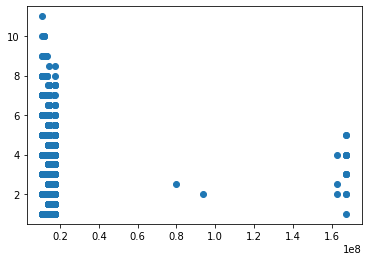

In [6]:
plt.scatter(train.parcelid, train.bathroomcnt);

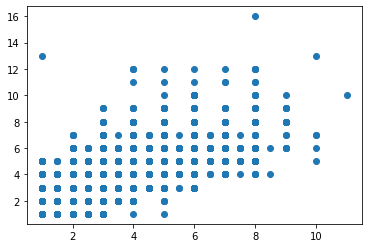

In [7]:
plt.scatter(train.bathroomcnt, train.bedroomcnt);

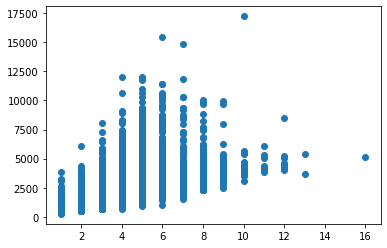

In [8]:
plt.scatter(train.bedroomcnt, train.calculatedfinishedsquarefeet);

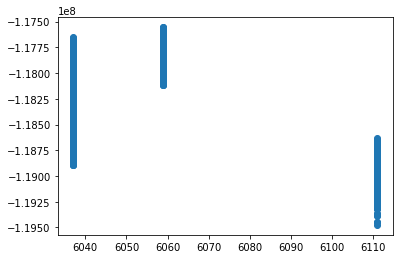

In [9]:
plt.scatter(train.fips, train.longitude);

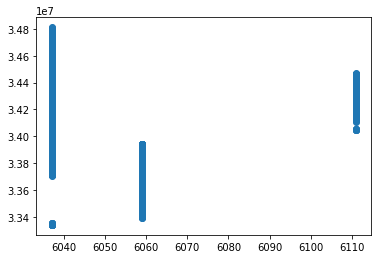

In [10]:
plt.scatter(train.fips, train.latitude);

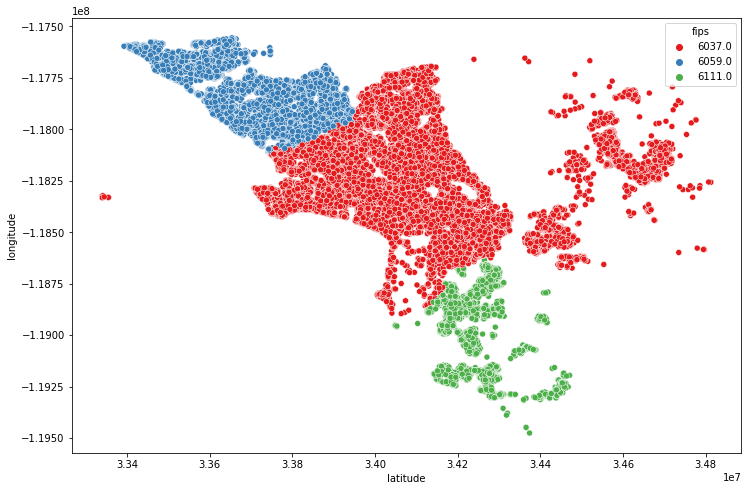

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(train.latitude, train.longitude, hue=train.fips, palette='Set1');

2. Plot a correlation matrix heatmap.

3. Plot latitude against longitude.

4. Create a useable plot with 4 dimensions, e.g. x, y, color, size.

5. Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

6. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?